In [6]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import torch
import os.path as osp
import json
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm
import glob
import pickle
IMG_DIR = '/home/chicm_dev/data/open-images/train/imgs'
TEST_IMG_DIR = '/home/chicm_dev/data/open-images/test'
MASK_DIR = '/home/chicm_dev/data/open-images/masks/train'
DATA_DIR = '/home/chicm_dev/data/open-images/segmentation'

In [7]:
!ls $DATA_DIR

challenge-2019-classes-description-segmentable.csv
challenge-2019-train-segmentation-bbox.csv
challenge-2019-train-segmentation-labels.csv
challenge-2019-train-segmentation-masks.csv
challenge-2019-validation-segmentation-bbox.csv
challenge-2019-validation-segmentation-labels.csv
challenge-2019-validation-segmentation-masks.csv
merge_0903_1.csv
sample_empty_submission-Copy1.csv
sample_empty_submission.csv
sample_empty_submission.csv.zip
sample_truncated_submission.csv
sub1_first_1000_test_add_parent.csv
sub1_first_1000_test.csv
sub1_first_1000_test_th001.csv
sub1_first_1000_test_top50.csv
sub_first_1000_0902_1_top50.csv
sub_first_1000_0902_2_top100.csv
sub_parent_0902_1000_1.csv
sub_parent_0903_1_top50.csv
top_classes.csv
top_classes_level1.csv
top_classes_parent.csv


In [8]:
df_des = pd.read_csv(osp.join(DATA_DIR, 'challenge-2019-classes-description-segmentable.csv'), names=['class', 'name'])
class_dict = df_des.set_index('class').to_dict()['name']

In [10]:
df_test = pd.read_csv(osp.join(DATA_DIR, 'sample_empty_submission.csv'))
df_test.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,-1,-1,NaN
1,52a76f3fe21185bf,-1,-1,NaN
2,65e9da7c04c8e4cd,-1,-1,NaN
3,6d10fa21d93bd6cc,-1,-1,NaN
4,0841dee573a875ca,-1,-1,NaN


In [11]:
def get_top_classes(start_index, end_index):
    df = pd.read_csv('top_classes_level1.csv')
    c = df['class'].values[start_index:end_index]
    #print(df.head())
    stoi = { c[i]: i for i in range(len(c)) }
    return c, stoi

In [12]:
classes, stoi = get_top_classes(0, 276)

In [13]:
classes[:5]

array(['/m/05r655', '/m/083wq', '/m/03bt1vf', '/m/04yx4', '/m/01xyhv'],
      dtype=object)

In [16]:
!ls /home/chicm_dev/open-images-seg/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x/*.pkl -lh

-rw-rw-r-- 1 chicm_dev chicm_dev  46M Sep  4 11:44 /home/chicm_dev/open-images-seg/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x/preds_0831_1_50.pkl
-rw-rw-r-- 1 chicm_dev chicm_dev  49M Sep  4 11:31 /home/chicm_dev/open-images-seg/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x/preds_0902_1_50_1000.pkl
-rw-rw-r-- 1 chicm_dev chicm_dev  69M Sep  4 11:44 /home/chicm_dev/open-images-seg/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x/preds_0902_2_100_1000.pkl
-rw-rw-r-- 1 chicm_dev chicm_dev 4.5G Sep  4 11:53 /home/chicm_dev/open-images-seg/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x/preds_0902_3_50_all_lb04195.pkl
-rw-rw-r-- 1 chicm_dev chicm_dev 4.9G Sep  4 16:38 /home/chicm_dev/open-images-seg/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x/preds_0904_1.pkl


In [17]:
with open('/home/chicm_dev/open-images-seg/work_dirs/cascade_mask_rcnn_x101_64x4d_fpn_1x/preds_0904_1.pkl', 'rb') as f:
    preds = pickle.load(f)

In [18]:
len(preds)

99999

In [19]:
len(preds[0][0])

276

In [20]:
preds[0][0]

[array([], shape=(0, 5), dtype=float32),
 array([[2.6710876e+02, 1.8043896e+02, 7.3513495e+02, 5.1950677e+02,
         1.9198614e-03],
        [2.6854874e+02, 1.9922404e+02, 4.1094083e+02, 4.4813455e+02,
         3.8764868e-03],
        [2.7354727e+02, 3.4844559e+02, 3.4913702e+02, 4.3985739e+02,
         2.9395989e-03],
        [2.7021069e+02, 2.7813925e+02, 3.3888211e+02, 4.3413379e+02,
         1.0703416e-03]], dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=float32),
 array([], shape=(0, 5), dtype=fl

In [21]:
import pycocotools.mask as mutils

In [22]:
mask1 = mutils.decode(preds[0][1][1][1])

In [23]:
mask1.shape

(683, 1024)

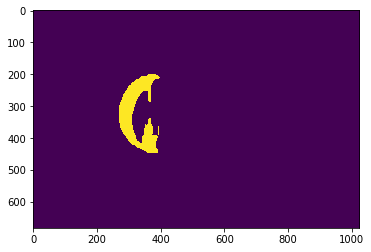

In [24]:
plt.imshow(mutils.decode(preds[0][1][1][1]))

In [25]:
# all root '/m/0bl9f'

with open('challenge-2019-label300-segmentable-hierarchy.json', 'r') as f:
    h = json.load(f)

leaf_classes = []
parent_classes = []
parent_dict = {}

def travel(root, parent=[]):
    if 'Subcategory' in root:
        parent_classes.append(root['LabelName'])
        for c in root['Subcategory']:
            travel(c, parent+[root['LabelName']])
    else:
        leaf_classes.append(root['LabelName'])
        parent_dict[root['LabelName']] = parent

travel(h)

FileNotFoundError: [Errno 2] No such file or directory: 'challenge-2019-label300-segmentable-hierarchy.json'

In [26]:
parent_dict['/m/029b3']

NameError: name 'parent_dict' is not defined

In [27]:
def get_mask(idx):
    box_pred, mask_pred = preds[idx]
    masks, labels, confs = [], [], []
    for i in range(len(classes)):
        for encoded_mask, bbox in zip(mask_pred[i], box_pred[i]):
            if True: #bbox[4] > 0.01:
                mask = mutils.decode(encoded_mask)
                masks.append(mask)
                labels.append(classes[i])
                confs.append(bbox[4])
                
                # add parent
                #for parent_class in parent_dict[classes[i]]:
                #    if parent_class != '/m/0bl9f':
                #        masks.append(mask)
                #        labels.append(classes[i])
                #        confs.append(bbox[4])
                
    return masks, labels, confs

In [28]:
def show_pred(idx):
    row = df_test.iloc[idx]
    fn = TEST_IMG_DIR + '/' + row.ImageID + '.jpg'
    img = cv2.imread(fn)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    masks, labels, confs = get_mask(idx)
    
    columns = 4
    plt.figure(figsize=(20, 15))
    
    plt.subplot(len(masks) / columns + 1, columns, 1)
    plt.imshow(img)
    plt.title(str(img.shape))
    
    for i, mask in enumerate(masks):
        plt.subplot(len(masks) / columns + 1, columns, i+2)
        if labels is not None:
            plt.title(class_dict[labels[i]] + str(mask.shape)+','+str(confs[i]))
        plt.imshow(mask)

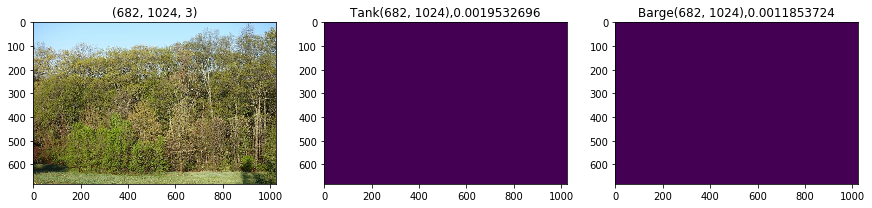

In [36]:
show_pred(2)

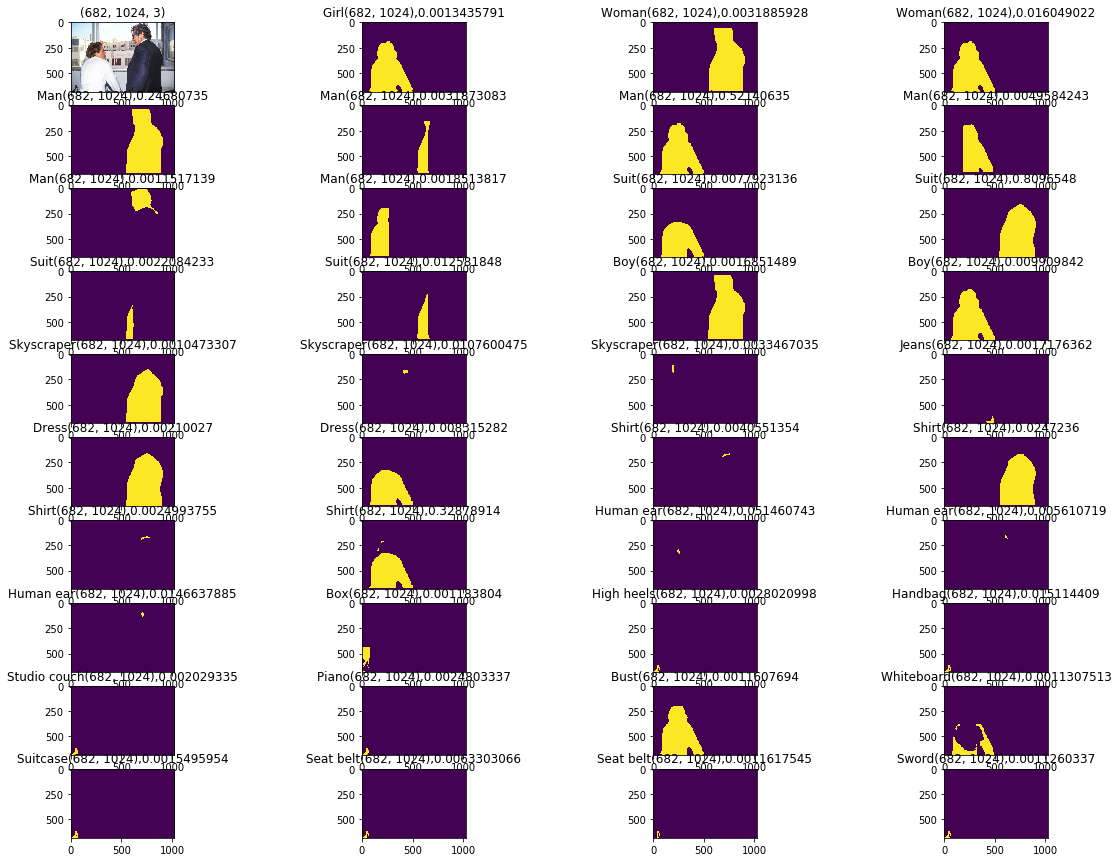

In [30]:
show_pred(3)

In [37]:
import struct
import imghdr

def get_image_size(fname):
    '''Determine the image type of fhandle and return its size.
    from draco'''
    with open(fname, 'rb') as fhandle:
        head = fhandle.read(24)
        if len(head) != 24:
            raise AssertionError('imghead len != 24')
        if imghdr.what(fname) == 'png':
            check = struct.unpack('>i', head[4:8])[0]
            if check != 0x0d0a1a0a:
                raise AssertionError('png check failed')
            width, height = struct.unpack('>ii', head[16:24])
        elif imghdr.what(fname) == 'gif':
            width, height = struct.unpack('<HH', head[6:10])
        elif imghdr.what(fname) == 'jpeg':
            try:
                fhandle.seek(0) # Read 0xff next
                size = 2
                ftype = 0
                while not 0xc0 <= ftype <= 0xcf:
                    fhandle.seek(size, 1)
                    byte = fhandle.read(1)
                    while ord(byte) == 0xff:
                        byte = fhandle.read(1)
                    ftype = ord(byte)
                    size = struct.unpack('>H', fhandle.read(2))[0] - 2
                # We are at a SOFn block
                fhandle.seek(1, 1)  # Skip `precision' byte.
                height, width = struct.unpack('>HH', fhandle.read(4))
            except Exception: #IGNORE:W0703
                raise
        else:
            print(fname, imghdr.what(fname))
            #raise AssertionError('file format not supported')
            img = cv2.imread(fname)
            print(img.shape)
            height, width, _ = img.shape

        return width, height


# create submission

In [38]:
def get_fn(img_id):
    return TEST_IMG_DIR + '/' + img_id + '.jpg'

In [39]:
df_test.ImageWidth = df_test.ImageID.map(lambda x: get_image_size(get_fn(x))[0])

In [40]:
df_test.ImageHeight = df_test.ImageID.map(lambda x: get_image_size(get_fn(x))[1])

In [41]:
df_test.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,1024,683,NaN
1,52a76f3fe21185bf,1024,683,NaN
2,65e9da7c04c8e4cd,1024,682,NaN
3,6d10fa21d93bd6cc,1024,682,NaN
4,0841dee573a875ca,1024,683,NaN


In [42]:
df_test['img_index'] = df_test.index
df_test.head()

,ImageID,ImageWidth,ImageHeight,PredictionString,img_index
0,80155d58d0ee19bd,1024,683,NaN,0
1,52a76f3fe21185bf,1024,683,NaN,1
2,65e9da7c04c8e4cd,1024,682,NaN,2
3,6d10fa21d93bd6cc,1024,682,NaN,3
4,0841dee573a875ca,1024,683,NaN,4


In [43]:
import base64
import numpy as np
from pycocotools import _mask as coco_mask
import typing as t
import zlib
def encode_binary_mask(mask: np.ndarray) -> t.Text:
    """Converts a binary mask into OID challenge encoding ascii text."""

    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError("encode_binary_mask expects a binary mask, received dtype == %s" % mask.dtype)

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError("encode_binary_mask expects a 2d mask, received shape == %s" % mask.shape)
    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode('utf-8')
    

In [44]:
encode_binary_mask(mask1>0)

'eNo90euSmkAQBeBXmhbZyAhWogxEgR4EBxBkcUUuctH3/5c22QpTxdfn1AxFQXWs9R7qmtEVfBx+7Fd73df8pad7+uHD14LlX5eBFmjvPtBwQUvzdJpB0hwsfVrBQjK5kCAB/3XvfVEw/upRbRTE2xYnK4Vy2+DNSqAnMzLcdRiSKdmZGZS7Fm9kTTk3U5gpH8nU7rFdJ1DZD6zWKdztDi/rDDoyo/y0aR+pRIsjT6EQHdb8DBXlL57Bl+jxkyfQigfmZCcGzLiCUYx44id4kiHl2BlwMhJIyN5QUDgj1uSVckXenAlLI4a788TciKAjz0YIivrB08PNzJRzGA1dOcFgaMrB0aCHycFgqcMe73suWw+jTccyR+sMHMWVKf7zJgZW8kRexBHu/IW5iKHlM2aCXpYPlBPqR7wI9W0CNfWlKKDkLdYiJ3usyCt/YLHt8LpoF2p9klc7hmL9KZXdsnFdynnXs9jM5HPXscg8y9euZUcz/29oNyw0i28HbOyIzhdYiBs0/BU02yeetMci5QnmTgetofDL6aEyUqzJ0kiwdeh7vNjVOsqH44Y+/ULrhbF7kbPXQGjNOLoRqNXz23c+kSNOroLTasDZTSAmJzel3OOTjFYP8mM6YGL5Lxcij52s/eguEw9epje57Owtp/eAF0/vzWBy/aun3015diHzfh9hWZmLo7sZ/FIqUx+dhs08l7G4s3Cdy0J8THx/0REY4LkJrT9aZfBm'

In [45]:
def get_pred_str(idx):
    masks, labels, confs = get_mask(idx)
    res = []
    for mask, label, conf in zip(masks, labels, confs):
        res.append(label)
        res.append('{:.7f}'.format(conf))
        res.append(encode_binary_mask(mask.astype(np.bool)))
    
    return ' '.join(res)

In [46]:
def set_pred_str(df):
    df['PredictionString'] = df.img_index.map(lambda x: get_pred_str(x))
    return df

In [47]:
from multiprocessing import Pool

def parallel_apply(df, func, n_cores=32):
    #ncores = 24
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


In [48]:
df_test = parallel_apply(df_test, set_pred_str)

In [49]:
df_test.shape

(99999, 5)

In [50]:
df_test = df_test.drop(columns=['img_index'], axis=1)
df_test.head()

,ImageID,ImageWidth,ImageHeight,PredictionString
0,80155d58d0ee19bd,1024,683,/m/083wq 0.0019199 eNp9U81uwyAMfiVDIO2pWm4dCXC...
1,52a76f3fe21185bf,1024,683,/m/083wq 0.0215510 eNqLTAq2DzKMTDFAAEN/A38jfyA...
2,65e9da7c04c8e4cd,1024,682,/m/07cmd 0.0019533 eNoLCIhKNQAABN0BkA== /m/01b...
3,6d10fa21d93bd6cc,1024,682,/m/05r655 0.0013436 eNqlk2mTmzAMhv+SOYIMu22nnY...
4,0841dee573a875ca,1024,683,/m/04yx4 0.0233356 eNqVVM0OwyAIfiWwbnuG/VSSHXb...


In [51]:
df_test.to_csv('sub_0904_1_top50.csv', index=False)

In [53]:
!kaggle competitions submit -c open-images-2019-instance-segmentation -f sub_0904_1_top50.csv -m "0904 night submit"

100%|██████████████████████████████████████| 1.69G/1.69G [00:37<00:00, 48.5MB/s]
Successfully submitted to Open Images 2019 - Instance Segmentation

In [54]:
!ls -lh

total 3.4G
-rw-rw-r-- 1 chicm_dev chicm_dev 543K Sep  4 11:02 check_preds.ipynb
-rw-rw-r-- 1 chicm_dev chicm_dev 535K Sep  4 11:02 check_preds-parent.ipynb
-rw-rw-r-- 1 chicm_dev chicm_dev 371K Sep  4 11:02 eda.ipynb
-rw-rw-r-- 1 chicm_dev chicm_dev  25K Sep  4 11:02 merge_df.ipynb
-rw-rw-r-- 1 chicm_dev chicm_dev 1.7G Sep  4 17:06 sub_0904_1_top50.csv
-rw-rw-r-- 1 chicm_dev chicm_dev 5.6M Sep  4 12:13 sub1_first_1000_test_add_parent.csv
-rw-rw-r-- 1 chicm_dev chicm_dev 4.4M Sep  4 12:13 sub1_first_1000_test.csv
-rw-rw-r-- 1 chicm_dev chicm_dev  11M Sep  4 12:13 sub1_first_1000_test_th001.csv
-rw-rw-r-- 1 chicm_dev chicm_dev  19M Sep  4 12:13 sub1_first_1000_test_top50.csv
-rw-rw-r-- 1 chicm_dev chicm_dev  19M Sep  4 12:13 sub_first_1000_0902_1_top50.csv
-rw-rw-r-- 1 chicm_dev chicm_dev  31M Sep  4 12:13 sub_first_1000_0902_2_top100.csv
-rw-rw-r-- 1 chicm_dev chicm_dev 353K Sep  4 17:08 submit.ipynb
-rw-rw-r-- 1 chicm_dev chicm_dev 344K Sep  4 11:02 submit-parent.ipynb
-rw-rw-r-- 1 chi

In [56]:
df_test.ImageHeight.value_counts()

682     25032
768     23412
1024    10907
683      4306
576      3935
680      3038
681      2656
678      2452
684      2220
685       854
767       761
575       756
731       572
765       433
960       321
640       290
577       265
686       231
732       209
959       198
512       191
687       178
679       174
666       165
614       149
691       148
668       139
704       136
703       135
724       133
        ...  
298         2
349         2
261         2
348         2
473         2
324         2
290         2
366         2
329         2
265         1
269         1
848         1
336         1
271         1
293         1
257         1
279         1
262         1
286         1
296         1
297         1
375         1
322         1
389         1
372         1
411         1
282         1
280         1
264         1
339         1
Name: ImageHeight, Length: 755, dtype: int64